# Parameterizing MD correlation functions

In the previous section, we learned how to derive order parameters and correlation functions from an MD trajectory. Now, the question is, how do we acquire NMR rate constants from the correlation functions. To begin, we give the formula for a few rate constants, where relaxation results from a single strong dipole coupling and chemical shift anisotropy (for backbone H–N motion that we will analyze here, these are sufficient terms to reproduce the relaxation).

$$
\begin{eqnarray}
R_1^I&=& \left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_I-\omega_S)+3J(\omega_I)+6J(\omega_I+\omega_S))+\frac13(\omega_I\Delta\sigma_I)^2J(\omega_I)\\
R_2^I&=& \frac12R_1^I+\left(\frac{\delta^{IS}}{4}\right)^2(J(\omega_S)+2J(0)+\frac29(\omega_I\Delta\sigma_I)^2J(0)\\
\Gamma_{IS}&=& \left(\frac{\delta^{IS}}{4}\right)^2(-J(\omega_I-\omega_S)+6J(\omega_I+\omega_S))
\end{eqnarray}
$$

These yield the orientationally averaged rate constants, which is relevant in solids where the relaxation is multiexponential (meaning we should be careful to extract the average rate when fitting to experiment and comparing). The critical terms are the sizes of the interactions ($\delta^{IS}$, $\omega_I\Delta\sigma_I$), and the frequencies at which the spectral densities are sampled (0, $\omega_S$, $\omega_I$, $\omega_I\pm\omega_S$).

The spectral density itself is given by the real part of the Fourier transform of the correlation function, that is:

$$
J(\omega)=2\int\limits_0^\infty{C(t)\cos(\omega t)dt}
$$

We usually assume that $C(t)$ is symmetric in time, so that we integrate from 0 instead of $-\infty$, and multiply by 2. A factor of 1/5 needs to appear in the correlation function to account for the isotropic average over starting orientations. This factor is sometime incorporated into the correlation function for overall tumbling, i.e. for isotropic tumbling the correlation function is $C(t)=\frac15\exp(-t/\tau_M)C_{int.}(t)$. However, if no overall tumbling is present because we are working in solids, then the factor of $1/5$ needs to nonetheless be included. Note that what we have calculated in the previous section is $C_{int.}(t)$

We could, in principle, Fourier transform the correlation functions from the previous section directly (after subtracting the order parameter away). Instead, what we usually do is assume the correlation function is a sum of exponentially decaying functions, and fit the corresponding parameters. 

$$
C_{int}(t)=S^2+\sum\limits_i{A_i\exp(-t/\tau_i)}
$$

Here, $S^2=1-\sum_i{A_i}$.

In the case that we have only internal motion (no tumbling), the spectral density may be written as follows, noting that the Fourier transform of an exponential is a Lorentzian function

$$
J(\omega)=2\sum\limits_i{A_i\frac{\tau_i}{1+(\omega\tau_i)^2}}
$$

However, if tumbling is included, we first need to calculate an effective correlation time. We'll revisit this later.

## Setup
We need to repeat the initial setup performed in the first notebook

In [1]:
# Make sure pyDR is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !git clone https://github.com/alsinmr/pyDR
else:
    os.chdir('../../..')

In [2]:
# imports
import pyDR
pyDR.Defaults['zrange']=[-14,-3,200]
from pyDR.Fitting.fit import model_free
from pyDR.MDtools import vft
from pyDR.misc.tools import linear_ex
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from time import time
from copy import copy

In [3]:
# Download the trajectory files
xtc='https://drive.google.com/file/d/1wq5T-YDmPo2zAIWu9we2zyL2i-v52fnD/view?usp=sharing'
pdb='https://drive.google.com/file/d/1aBMUO2C1AZfx05dANl4QITHuqmHbDDsN/view?usp=sharing'

if not(os.path.exists('ubi.pdb')):
    pyDR.IO.download(pdb,'ubi.pdb')
if not(os.path.exists('ubi.xtc')):
    pyDR.IO.download(xtc,'ubi.xtc')

In [4]:
def align(uni,fileout='ubi_aligned.xtc',ref_sel='name CA'):
    """
    This function takes a trajectory and aligns it based on
    a reference selection of atoms. The new trajectory is
    returned in fileout (default is ubi_aligned.xtc)
    """
    
    from scipy.linalg import svd
    
    uni.trajectory[0] #Go to the first frame of the trajectory
    atoms=uni.atoms   #All atoms in the trajectory
    ref_sel=uni.select_atoms(ref_sel)  #Atom group for the reference
    
    ref0=ref_sel.positions #initial positions of reference atoms
    ref0-=ref0.mean(0) #Centers the initial position
    
    with mda.Writer(fileout,atoms.n_atoms) as W:
        for ts in uni.trajectory:
            ref=ref_sel.positions
            pos=atoms.positions

            pos-=ref.mean(0)   #This centers the reference
            ref-=ref.mean(0)   
            
            H=ref0.T@ref       #3x3 matrix
            U,S,Vt=svd(H)      #Singular value decomposition
            V=Vt.T             #Transposes
            Ut=U.T

            R=V@Ut             #Rotation matrix for alignment
            
            pos_corr=(R.T@pos.T).T
            atoms.positions=pos_corr
            
            W.write(atoms)
    return

In [5]:
uni0=mda.Universe('ubi.pdb','ubi.xtc')
if not(os.path.exists('ubi_aligned.xtc')):
    align(uni0,fileout='ubi_aligned.xtc')   #Runs the code to align Ubiquitin in the universe
uni=mda.Universe('ubi.pdb','ubi_aligned.xtc')  #Loads the aligned trajectory

## pyDIFRATE initial data load
We'll work with pyDIFRATE in this notebook. We'll start with a project (`proj=pyDR.Project`) and load NMR data into it which is downloaded online, and also load correlation functions into it from an MD trajectory.

pyDIFRATE does a lot of things for you automatically. The advantage here is that we'll get through the problems more quickly, but the downside is that you'll have to accept that some of the parameters are indeed calculated correctly ;-).

In [6]:
def load_proj():
    proj=pyDR.Project()
    proj.append_data('https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/data/ubi_soln.txt')
    data=proj[0].__copy__()
    R00=data.R[0,0]
    data.R[0,0]=0
    data.sens=pyDR.Sens.NMR(info=data.sens.info)
    proj.append_data(data)
    data.R[0,0]=R00
    proj[-1].source.filename='ubi.text'


    sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi_aligned.xtc',project=proj)
    sel.select_bond('15N')
    pyDR.md2data(sel)

    sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi.xtc',project=proj)
    sel.select_bond('15N')
    pyDR.md2data(sel)


    return proj

In [7]:
proj=load_proj()

# Time axis for correlation functions
data=proj['raw']['MD'][0]
t=data.sens.info['t']  #ns

# Residues in the simulation
resids=data.label
print(proj)

Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
pyDIFRATE project with 4 data sets

titles:
r:NMR:ubi_soln
r:NMR:ubi
r:MD:ubi_aligned
r:MD:ubi



## Part 1: Directly calculate the spectral density
We can obtain the spectral density via Fourier transform of the correlation function. 

We first note that the correlation functions and order parameters are stored in the project. We plot one for example.

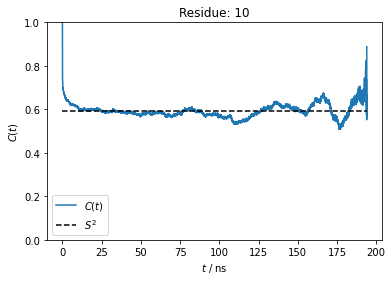

In [15]:
resi=10
i=np.argmax(resids==resi) # Finds where this is true  
data=proj['MD']['raw']['.+aligned']  #Finds the unprocessed MD data

ax=plt.subplots()[1]
ax.plot(t,data.R[i])
ax.plot(t[[0,-1]],np.ones(2)*data.S2[i],color='black',linestyle='--')
ax.set_xlabel(r'$t$ / ns')
ax.set_ylabel(r'$C(t)$')
ax.set_title(f'Residue: {resi}')
ax.legend((r'$C(t)$',r'$S^2$'))
_=ax.set_ylim([0,1])

Plot the spectral density for a few residues (code below)

In [18]:
resi=2
i=np.argmax(resids==resi) # Finds where this is true  
Ct=data.R[i]-data.S2[i]
Ct[0]/=2  #Single-sided FT, need to cut first point in half
dt=(t[1]-t[0])*1e-9
J=2*np.fft.fftshift(np.fft.fft(Ct[:len(Ct)//2],n=len(Ct))).real*dt

f=1/(2*dt)*np.linspace(-1,1,len(t))/1e6
f-=(f[1]-f[0])/2

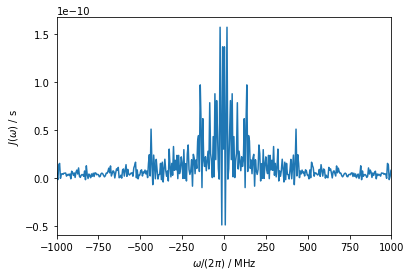

In [19]:
ax=plt.subplots()[1]
ax.plot(f,J)
ax.set_xlabel(r'$\omega/(2\pi)$ / MHz')
ax.set_ylabel(r'$J(\omega)$ / s')
_=ax.set_xlim([-1000,1000])

### Exercise 1.1
Why do we recommend fitting the correlation function rather than taking the correlation function directly?

```{toggle}
The Fourier transform is too noisy to be used to get reliable rate constants. With smoothing or fitting, it can, however, provide reliable results.

We instead fit the correlation function as a multi-exponential decay and use the parameters in the expression above for the spectral density, $J(\omega)$.
```

## Part 2: Multi-exponential fitting (model-free-like analysis)
In the hidden cell, we define a class below to extract model free parameters from MD-derived correlation functions, that also includes a variety of plotting functions.

In [106]:
class MF():
    def __init__(self,n:int=5,aligned:bool=True,Type='MD',proj=proj):
        self._Type=Type
        self.proj=proj
        self._n=None
        self.aligned=aligned
        self._z=None
        self._A=None
        self.fit=None
        self.chi2=None
        self.n=n
    
    @property
    def Type(self):
        return self._Type
    
    @Type.setter
    def Type(self):
        assert 0,'Type (MD/NMR) cannot be changed after initialization'
        
    def _title(self,pre):
        if pre=='n':
            pre='n12' if self.Type=='MD' else 'n6'
            
        if self.Type=='MD':
            return f'{pre}:MD:ubi'+('_aligned' if self._aligned else '$')
        return f'{pre}:NMR:ubi'+('_soln' if self._aligned else '$')
    
    def _mdtitle(self,pre):
        return f'{pre}:MD:ubi'+('_aligned' if self._aligned else '$')
                
    @property
    def n(self):
        return self._n
    
    @n.setter
    def n(self,n):
        if hasattr(self,'_n') and n==self._n:
            return
        self._n=n
        if len(proj[self._title(f'p{n}')])==0:
            self.proj[self._title('n')].detect.r_auto(n=n)
            self.proj[self._title('n')].fit()
        data=proj[self._title(f'p{n}')][0]

        fixz=[-14,*[None for _ in range(self.nz-1)]] if n%2 else None
            
        z,A,chi2,fit=model_free(data,self.nz,fixz=fixz,include=[True for _ in range(n)])
        self.z=z
        self.A=A
        self.fit=fit
        self.chi2=chi2
        
    @property
    def nz(self):
        return np.ceil(self.n/2).astype(int)
        
    @property
    def aligned(self):
        return self._aligned
    
    @aligned.setter
    def aligned(self,aligned):
        if hasattr(self,'_aligned') and self._aligned==aligned:
            return
        
        self._aligned=aligned
        
        nd=12 if self.Type=='MD' else 6
        if len(proj[self._title('n')])==0:
            proj[self._title('r')].detect.r_no_opt(nd)
#             if self.Type!='MD':proj[self._title('r')][0].detect.R2ex()
            proj[self._title('r')].fit()
#             proj[self._title('n')].del_exp(index=-1)
        
        if self._n is not None:
            n=self.n    #Force a re-calculation
            self._n=0  
            self.n=n
        
    @property
    def tc(self):
        return 10**self.z
    
    @property
    def S2_fit(self):
        return 1-self.A.sum(0)
    
    @property
    def S2(self):
        return self.proj[self._title('r')].S2
    
    @property
    def resids(self):
        return self.proj[self._title('r')].label
    
    @property
    def t(self):
        return self.proj['MD']['raw']['ubi_aligned'].info['t'].astype(float)
    
    def plot_pars(self,ax:list=None):
        if ax is None:
            fig,ax=plt.subplots(self.nz,2,sharex=True)
        for k,ax0 in enumerate(ax):
            i=self.A[k]>1e-3
            ax0[0].scatter(self.resids[i],self.A[k][i],s=5,color='red')
            ax0[0].set_ylabel('A')
            ax0[1].scatter(self.resids[i],self.z[k][i],s=5,color='red')
            ax0[1].set_ylabel(r'$\log_{10}(\tau_c$ / s$)$')
            if ax0[0].is_last_row():
                for a in ax0:a.set_xlabel('Residue')
        
        fig.set_size_inches([8,9])
        fig.tight_layout()
        return ax
    
    @property
    def Ct_fit(self):
        ct=np.ones([len(self.t),len(self.resids)])*self.S2_fit
        for tc0,A0 in zip(self.tc,self.A):
            ct+=np.exp(-np.kron(np.atleast_2d(self.t*1e-9).T,np.atleast_2d(1/tc0)))*A0
        return ct.T
    
    @property
    def Ct(self):
        return self.proj[self._mdtitle('r')].R
    
    def plot_ct(self,resi:int,semilog=False,show_fit=None,ax=None):
        if ax is None:
            ax=plt.subplots()[1]
        i=self.resids==resi
        assert np.any(i),'No data for selected residue'
        i=np.argmax(i)
        
        if show_fit is None:show_fit=self.Type=='MD'
        
        plot=ax.semilogx if semilog else ax.plot
        if show_fit:
            i0=np.argmax(self.proj['MD']['raw'][0].label==resi)
            plot(self.t,self.Ct[i0],color='red')
            plot(self.t,self.Ct_fit[i],color='black',linestyle='--')
            ax.legend(('MD','fit'))
        else:
            plot(self.t,self.Ct_fit[i],color='red')
        ax.set_xlabel(r'$t$ / ns')
        ax.set_ylabel(r'$C(t)$')
        ax.set_title(f'Residue: {resi}')

        return ax
    
    @property
    def data(self):
        return self.proj[self._title(f'p{self.n}')][0]
    
    @property
    def nmr_data(self):
        return self.proj['r:NMR:ubi'+('_soln' if self.aligned else '')][0]
        
    @property
    def nmr_sens(self):
        return self.nmr_data.sens
    
    @property
    def relax_rates(self):
        R=np.ones([len(self.resids),self.nmr_sens.rhoz.shape[0]])*self.nmr_sens.R0
        for z0,A0 in zip(self.z,self.A):
            R+=(A0*linear_ex(self.nmr_sens.z,self.nmr_sens.rhoz,z0)).T
        return R
    
    @property
    def det_relax_rates(self):
        assert self.Type=='MD','Relaxation rates from detectors only from MD'
        data=self.proj[self._title('n')]
        data.detect.r_target(target=self.nmr_sens.rhoz)
        self.proj.remove_data(-1)
        return data.R
    
    def plot_rates(self,det=False,ax=None):
        if ax is None:
            fig,ax=plt.subplots(3,3)
            ax=ax.flatten()
        else:
            fig=ax[0].figure
        rates=self.det_relax_rates if det else self.relax_rates
        for k,a in enumerate(ax):
            a.bar(self.nmr_data.label,self.nmr_data.R[:,k],color=plt.get_cmap('tab10')(k),zorder=0)
            a.scatter(self.resids,self.relax_rates[:,k],s=10,color='black',zorder=10)
            Type=self.nmr_data.info[k]["Type"]
            if len(Type)==2:Type=rf'${Type[0]}_{Type[1]}$'
            a.set_title(Type+f' @ {self.nmr_data.info[k]["v0"]} MHz')
        fig.set_size_inches([11,9])
        fig.tight_layout()
        return ax
    
    def plot_fit(self):
        self.proj.close_fig('all')
        self.data.plot(style='bar')
        self.fit.plot(style='s')
        return self.proj.plot_obj

### Investigate the quality of multi-exponential fitting of the correlation function

The value of `n` below determines how many parameters are used to fit the correlation times. If an even value is used, then we have $n/2$ pairs of amplitudes and correlation times to fit the correlation function. If an odd value is used, then we have $(n-1)/2$ pairs of amplitudes and correlation times, plus a single "fast" motion, which will have an arbitrarily short. correlation time (it will account for the decay between the first two time points of the correlation function)

### Exercise 2.1
Adjust `n` below until you're satisfied with the fit of the correlation functions. A sample of correlation functions is plotted to see the fit quality (if you get the plotted correlation functions to fit, the other correlation functions should be ok, but you may also adjust which correlation functions to see, for example, by changing `mf.resids[10::4]` to `mf.resids[1::4]`, which adjusts the first correlation function to show). 

What value of `n` do you get?

In [59]:
mf=MF(n=3)

Iterations |██████████████████████████████| 100%  of 16 steps
Completed
Data already in project (index=11)


In [107]:
mf=MF(n=7)

Iterations |██████████████████████████████| 100%  of 64 steps
Completed
Data already in project (index=6)


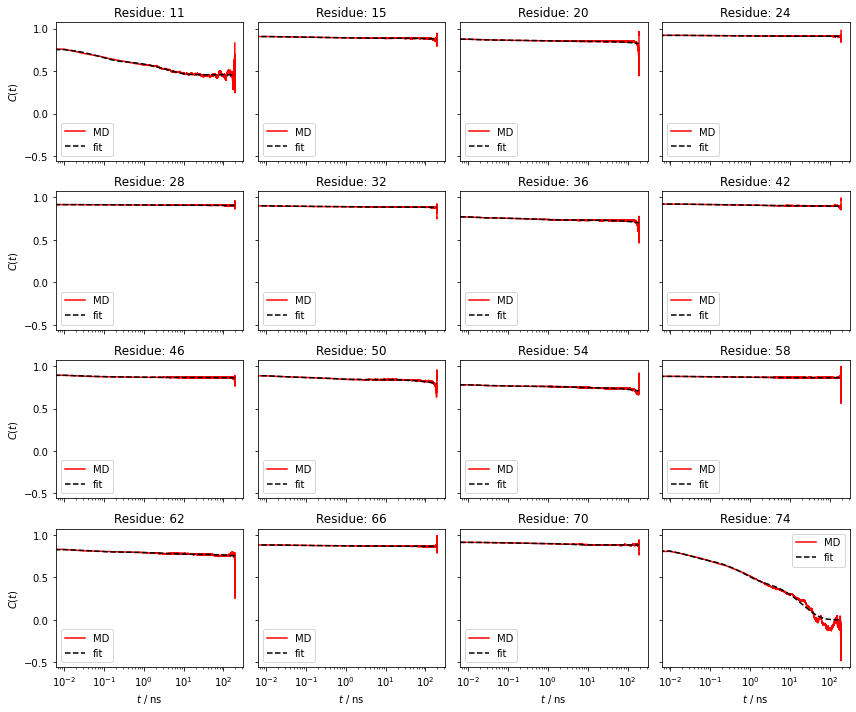

In [115]:
fig,ax=plt.subplots(4,4,sharex=True,sharey=True,figsize=[12,10])
ax=ax.flatten()
for a,resi in zip(ax,mf.resids[9::4]):
    mf.plot_ct(resi=resi,semilog=True,ax=a)
    if not(a.is_first_col()):
        a.set_ylabel('')
    if not(a.is_last_row()):
        a.set_xlabel('')
fig.tight_layout()

```{toggle}
Some disagreement between correlation function and fit is still present for `n=6`, but for `n=7`, most features are well reproduced
```

### Exercise 2.2
Repeat exercise 2.1 but without alignment. What value of $n$ do you get? Why is it different?

In [67]:
mfNA=MF(n=5,aligned=False)

Fitted 1 data objects
Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 16 steps
Completed


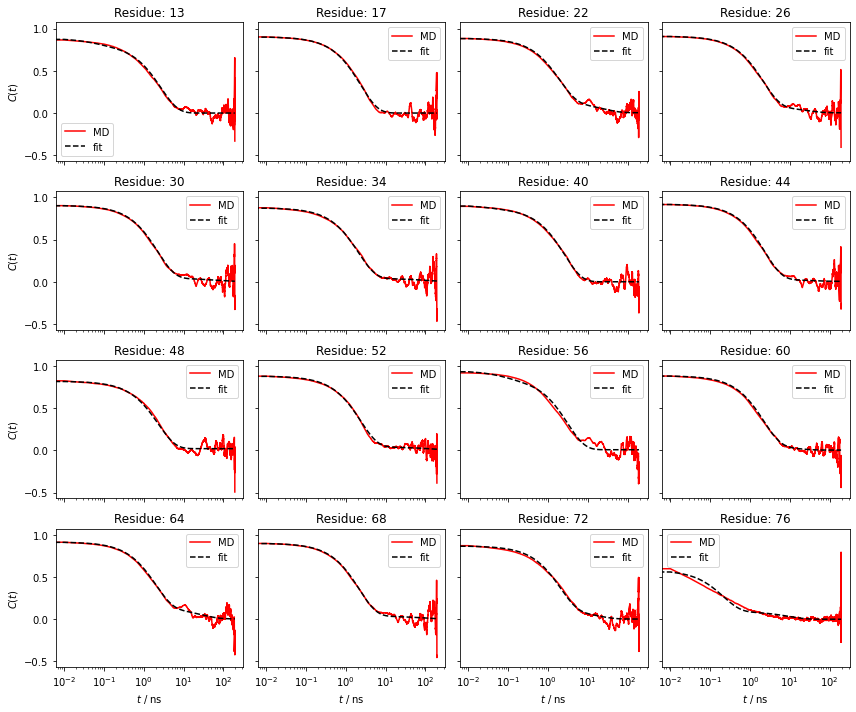

In [70]:
fig,ax=plt.subplots(4,4,sharex=True,sharey=True,figsize=[12,10])
ax=ax.flatten()
for a,resi in zip(ax,mfNA.resids[11::4]):
    mfNA.plot_ct(resi=resi,semilog=True,ax=a)
    if not(a.is_first_col()):
        a.set_ylabel('')
    if not(a.is_last_row()):
        a.set_xlabel('')
fig.tight_layout()

```{toggle}
Most residues fit quite well for `n=5`, with a few exceptions near the C-terminus. This is because the overall tumbling masks some of the slower motions, and prevents them from manifesting in the correlation function. Then, we no longer need the extra parameters to fit them.

Bonus: Overall tumbling is present in the experimental data, so does it matter if these motions get covered up, if our main goal is to compare to experiment? (answer in next toggle box)
```

```{toggle}
Yes- the problem is, that tumbling in the MD is occuring more quickly than in the real solution, so these motions are not masked experimentally. Then, we still need to extract them from the MD, which we cannot properly do if they are concealed by the tumbling
```

### Exercise 2.3
Plot the model free parameters below. Are the fit parameters reliable? What does the slowest correlation time and corresponding amplitude tell us. The fastest correlation time was fixed to 10 femtoseconds. What does this correlation time and amplitude tell us?

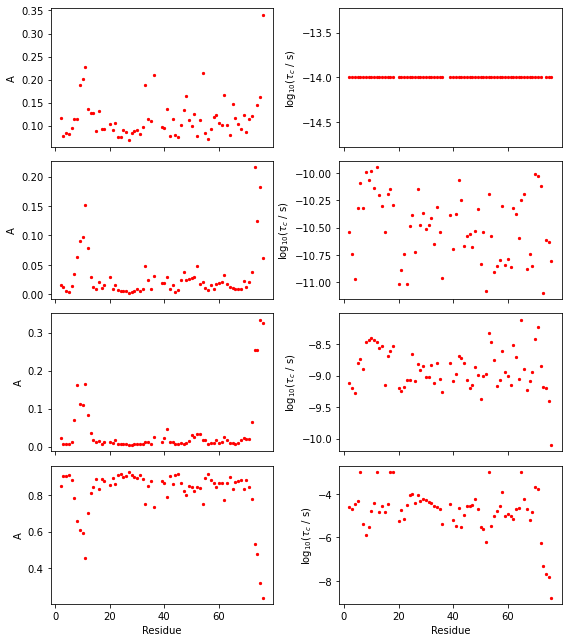

In [73]:
_=mf.plot_pars()

```{toggle}
There is a great deal of scatter in the correlation times, so that they perhaps should not be regarded as too reliable. We will later see that they are still helpful for calculating relaxation rate constants.

The slowest correlation time is mostly acting as the order parameter, $S^2$. The trajectory is about $2\cdot10^-7$ s long, so any correlation time an order of magnitude slower than that will not lead to any visible decay during the trajectory. So, we really cannot use these correlation times, and the amplitudes simply represent the fraction of the correlation function that did not decay during the trajectory. It may decay eventually, or may not, so there may be more, slower motion, or not.

The fastest correlation should not be interpreted directly. It is motion that is simply significantly faster than the recorded timestep (10 ps). The amplitude is the size of the fast decay.
```

## Part 3: Calculating relaxation rate constants
We can use the formulas at the beginning of this document to calculate relaxation constants for various experiments. Note that to reproduce an experiment, we need to account for the total motion, which includes tumbling (that we have factored out). It will be useful to note that tumbling occurs for ubiquitin with a correlation time of 4.84 ns. The total correlation function is given by

$$
\begin{eqnarray}
C(t)&=&C_{tumbl.}(t)\cdot C_{int.} \\
&=&\frac15\exp(-t/\tau_M)\left(S^2+\sum\limits_i{A_i\exp(-t/\tau_i)}\right) \\
&=&\frac15\left(S^2\exp(-t/\tau_M)+\sum\limits_i{A_i}\exp(-t/\tau^i_{eff})\right)
\end{eqnarray}
$$

With definitions

$$
\begin{eqnarray}
S^2&=&1-\sum_i{A_i} \\
\tau_{eff}^i&=&\frac{\tau_i\tau_M}{\tau_i+\tau_M}
\end{eqnarray}
$$

Then, to obtain the relaxation rate constants, we have a few steps:

1. Calculate the order parameter

2. Calculate the effective correlation times

3. For each effective correlation time and the overall tumbling
    
    * Calculate the spectral density at the required frequencies
    * Add all terms
    * Scale by the interaction strengths
    
4. Add all terms together

### Exercise 3.1
Write a function for the effective correlation time ($\tau_{eff}^i)$ given the internal correlation time ($\tau_i$) and the correlation time of tumbling ($\tau_M$). This has been started for you: just fill in the line `return ...`, replacing `...` with the correct formula. Try the formula, and see how it behaves if the internal motion is a lot faster, a lot slower, or similar to the correlation time of the tumbling.

In [ ]:
def tcEff(ti,tM):
    return ...

In [126]:
def tcEff(ti,tM):
    return ti*tM/(ti+tM)

In [137]:
tcEff(np.array([1e-7,1e-9,1e-11]),1e-9)

array([9.9009901e-10, 5.0000000e-10, 9.9009901e-12])

```{toggle}
If the internal motion is much slower than the tumbling, then the returned value is close to the correlation time of the tumbling. If it is much faster, then the returned value is close to the input value. If they are similar, then we end up with a value slightly shorter than the input (in this example, by half when $\tau_i=\tau_M$)
```

### Exercise 3.2
Write a function for the spectral density from a single correlation time with inputs of amplitude (`A`), correlation time (`tc`), and frequency (`v`, give in MHz). Plot the spectral density as a function of correlation time (on a log scale) for a fixed field, and as a function of frequency (for a fixed correlation time). You can set `A=1` for these calculations. Which of these functions has a well-defined maximum, and where is it? 

Note, in Python, to obtain a power, use the `**` symbol (e.g. `2**3=8`).

In [175]:
def J(A,tc,v):
    omega=2*np.pi*1e6   #Convert MHz to rad/s
    return ...

In [176]:
def J(A,tc,v):  #v in MHz
    omega=2*np.pi*1e6*v
    return 2*A*tc/(1+(omega*tc)**2)

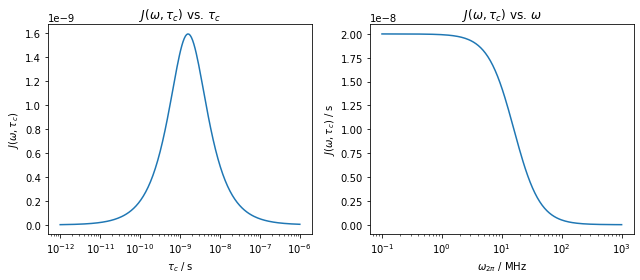

In [205]:
fig,ax=plt.subplots(1,2,figsize=[9,4])
tc=np.logspace(-12,-6,200)
ax[0].semilogx(tc,J(1,tc,100))
ax[0].set_xlabel(r'$\tau_c$ / s')
ax[0].set_ylabel(r'$J(\omega,\tau_c)$')
ax[0].set_title(r'$J(\omega,\tau_c)$ vs. $\tau_c$')
v0=np.logspace(-1,3,200)
ax[1].semilogx(v0,J(1,1e-8,v0))
ax[1].set_xlabel(r'$\omega_{2\pi}$ / MHz')
ax[1].set_title(r'$J(\omega,\tau_c)$ vs. $\omega$')
ax[1].set_ylabel(r'$J(\omega,\tau_c)$ / s')
fig.tight_layout()

```{toggle}
As a function of correlation time, the spectral density has a maximum when $1/\tau_c=\omega$ (in rad/s, not in Hz). The spectral density as a function of frequency becomes larger with decreasing frequency, and plateaus at $2\tau_c$
```

### Exercise 3.3
Below is a function for calculating $R_1$ from a list of correlation times (`tc`) and amplitudes (`A`), in addition to the tumbling correlation time (`tM`), and the magnetic field in MHz ($^1$H frequency). Following this approach, write a function for the heteronuclear NOE and R2. Note the $^{15}N$ Larmor frequency is -1/9.862 times the $^1$H Larmor frequency.

In [120]:
print(f'Ratio of Larmor frequencies: {pyDR.tools.NucInfo("1H")/pyDR.tools.NucInfo("15N"):.3f}')

Ratio of Larmor frequencies: -9.862


In [160]:
# The required interaction anisotropy parameters are stored in pyDR
delta=proj[0].sens.info[0]['dXY']
DelSigma=proj[0].sens.info[0]['CSA']*3/2

def R1(tM,tc,A,v0H):  #v0H in MHz
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times
    
    # 1) Relaxation due to tumbling + dipole coupling
    R1=(2*np.pi*delta/4)**2*(J(S2,tM,v0H-v0N)+3*J(S2,tM,v0N)+6*J(S2,tM,v0H+v0N))
    # 2) Relaxation due to tumbling + CSA
    R1+=1/3*(2*np.pi*v0N*DelSigma)**2*J(S2,tM,v0N)
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 3) Internal motion + dipole
        R1+=(2*np.pi*delta/4)**2*(J(A0,tc0,v0H-v0N)+3*J(A0,tc0,v0N)+6*J(A0,tc0,v0H+v0N))
        # 4) Internal motion + CSA
        R1+=1/3*(2*np.pi*v0N*DelSigma)**2*J(A0,tc0,v0N)
        
    return R1/5 #Don't forget the 1/5!

In [ ]:
def R2(tM,tc,A,v0H):
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times

    # 0) R1 contributions
    R2=R1(tM,tc,A,v0H)
    # 1) Relaxation due to tumbling + dipole coupling
    R2+=...
    # 2) Relaxation due to tumbling + CSA
    R2+=...
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 3) Internal motion + dipole
        R2+=...
        # 4) Internal motion + CSA
        R2+=...
        
    return R2/5 #Don't forget the 1/5!

def NOE(tM,tc,A,v0H):
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times

    # 1) Relaxation due to tumbling + dipole coupling
    NOE+=...
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 2) Internal motion + dipole
        NOE+=...
        
    return ... #Don't forget the 1/5!

In [165]:
def R2(tM,tc,A,v0H):
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times

    # 0) R1 contributions
    R2=R1(tM,tc,A,v0H)
    # 1) Relaxation due to tumbling + dipole coupling
    R2+=(2*np.pi*delta/4)**2*(3*J(S2,tM,v0H)+3*J(S2,tM,0))
    # 2) Relaxation due to tumbling + CSA
    R2+=2/9*(2*np.pi*v0N*DelSigma)**2*J(S2,tM,0)
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 3) Internal motion + dipole
        R2+=(2*np.pi*delta/4)**2*(3*J(A0,tc0,v0H)+2*J(A0,tc0,0))
        # 4) Internal motion + CSA
        R2+=2/9*(2*np.pi*v0N*DelSigma)**2*J(A0,tc0,0)
        
    return R2/5 #Don't forget the 1/5!

def NOE(tM,tc,A,v0H):
    v0N=-v0H/9.862
    S2=1-A.sum(0) # Could use multi-dimensional inputs
    tceff=tcEff(tc,tM) #Effective correlation times

    # 1) Relaxation due to tumbling + dipole coupling
    NOE=(2*np.pi*delta/4)**2*(-J(S2,tM,v0H-v0N)+6*J(S2,tM,v0H+v0N))
    
    for tc0,A0 in zip(tceff,A):  #Now loop over internal motions with effective tc
        # 2) Internal motion + dipole
        NOE+=(2*np.pi*delta/4)**2*(-J(A0,tc0,v0H-v0N)+6*J(A0,tc0,v0H+v0N))
        
    return NOE/5 #Don't forget the 1/5!

### Plot your results
Plot results below for a few fields

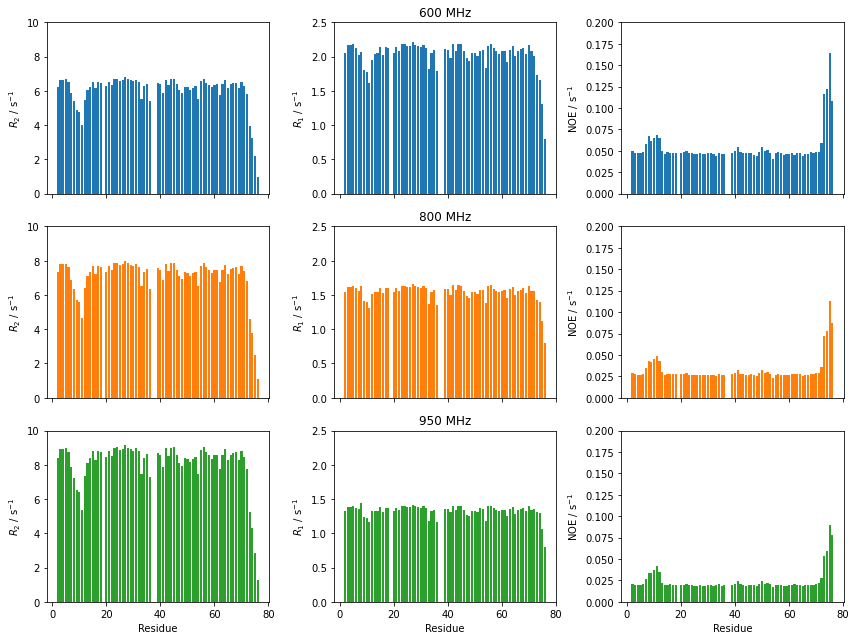

In [189]:
tM=4.84e-9   #Correlation time for ubiquitin in solution
cmap=plt.get_cmap('tab10')

fig,ax=plt.subplots(3,3,figsize=[12,9],sharex=True)

for k,(ax0,v0H) in enumerate(zip(ax,[600,800,950])):
    ax0[0].bar(mf.resids,R2(4.84e-9,mf.tc,mf.A,v0H),color=cmap(k))
    ax0[1].bar(mf.resids,R1(4.84e-9,mf.tc,mf.A,v0H),color=cmap(k))
    ax0[2].bar(mf.resids,NOE(4.84e-9,mf.tc,mf.A,v0H),color=cmap(k))
    for a,exp in zip(ax0,[r'$R_2$',r'$R_1$','NOE']):
       a.set_ylim([0,a.get_ylim()[1]])
       a.set_ylabel(exp+r' / s$^{-1}$')
    ax0[1].set_title(f'{v0H} MHz')
for a in ax[-1]:a.set_xlabel('Residue')
       
for ax0,yl in zip(ax.T,[10,2.5,.2]):
    for a in ax0:a.set_ylim([0,yl])
    
fig.tight_layout()

### Exercise 3.4
How does each experiment change as a function of field, and what drives this behavior?

```{toggle}
$R_1$ and NOE both exhibit slower rates as a function of field. This can be understood since the spectral density decreases with increasing field. $R_2$, on the other hand, increases with field. This is due to the growth of the term $(\omega_I\Delta\sigma_i)^2$ with increasing field (the term $J(0)$ dominates for $R_2$, so changes in the spectral density are less important). 

Note that the negative field dependence of $R_1$ and $NOE$ indicates the presence of slower motions. If only fast motions are present, then the spectral density is constant, and so these rate constants will then also grow with field due to increased contributions from CSA relaxation.
```

## Part 4: Comparing to experiment
Above, we downloaded experimental relaxation rate constants from Charlier et al. Note that the correlation time of tumbling we used previously (4.84 ns) is extracted from this data set. Now we will compare these to our calculated results. Plotting is set up for you below.

C. Charlier, S.N. Khan, T. Marquardsen, P. Pelupessy, V. Reiss, D. Sakellariou, G. Bodenhausen, F. Engelke, F. Ferrage. [*J. Am. Chem. Soc.*](https://doi.org/10.1021/ja409820g), **2013**, 135, 18665

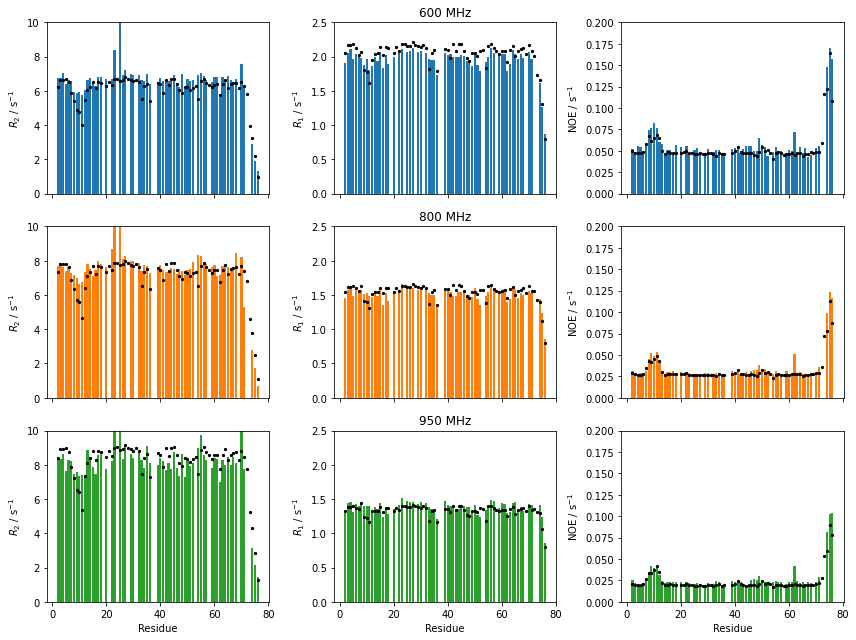

In [212]:
tM=4.84e-9   #Correlation time for ubiquitin in solution

fig,ax=plt.subplots(3,3,figsize=[12,9],sharex=True)

for k,(ax0,v0H) in enumerate(zip(ax,[600,800,950])):
    i=np.argmax(np.logical_and(mf.nmr_data.info['v0']==v0H,mf.nmr_data.info['Type']=='R2'))
    ax0[0].bar(mf.nmr_data.label,mf.nmr_data.R[:,i],color=cmap(k))
    ax0[0].scatter(mf.resids,R2(4.84e-9,mf.tc,mf.A,v0H),s=5,color='black',zorder=10)
    i=np.argmax(np.logical_and(mf.nmr_data.info['v0']==v0H,mf.nmr_data.info['Type']=='R1'))
    ax0[1].bar(mf.nmr_data.label,mf.nmr_data.R[:,i],color=cmap(k))
    ax0[1].scatter(mf.resids,R1(4.84e-9,mf.tc,mf.A,v0H),s=5,color='black',zorder=10)
    i=np.argmax(np.logical_and(mf.nmr_data.info['v0']==v0H,mf.nmr_data.info['Type']=='NOE'))
    ax0[2].bar(mf.nmr_data.label,mf.nmr_data.R[:,i],color=cmap(k))
    ax0[2].scatter(mf.resids,NOE(4.84e-9,mf.tc,mf.A,v0H),s=5,color='black',zorder=10)
    for a,exp in zip(ax0,[r'$R_2$',r'$R_1$','NOE']):
       a.set_ylim([0,a.get_ylim()[1]])
       a.set_ylabel(exp+r' / s$^{-1}$')
    ax0[1].set_title(f'{v0H} MHz')
for a in ax[-1]:a.set_xlabel('Residue')
       
for ax0,yl in zip(ax.T,[10,2.5,.2]):
    for a in ax0:a.set_ylim([0,yl])
    
fig.tight_layout()

### Exercise 4.1
How do the results compare to experiment? What does this tell you about the quality of the MD simulation?

```{toggle}
Results are in fairly good agreement with experiment. However, keep in mind that we have used the experimentally determined correlation time of tumbling (4.84 ns) to calculate these rate constant, where a big contribution to the relaxation is coming from the tumbling. Agreement between features, however, is a stronger indicator of good MD performance, where we see particularly good reproduction, for example, for NOE at 800 and 950 MHz, although worse behavior for $R_1$ and $R_2$ (although not terrible).
```

The object below allows model-free fitting of the *NMR* data. How many parameters (`n`) are sufficient to fit the data? Evaluate by eye via the `plot_rates` function.

In [225]:
for n in [2,3,4,5,6]:
    mf_nmr=MF(Type='NMR',n=n)
    print(f'{n}: {mf_nmr.chi2.sum():.1f}')

Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 1 steps
Completed
2: 3.4
Iterations |██████████████████████████████| 100%  of 4 steps
Completed
Data already in project (index=21)
3: 1.8
Iterations |██████████████████████████████| 100%  of 4 steps
Completed
Data already in project (index=23)
4: 79.1
Iterations |██████████████████████████████| 100%  of 16 steps
Completed
Data already in project (index=9)
5: 35.1
Fitted 1 data objects
Iterations |██████████████████████████████| 100%  of 16 steps
Completed
6: 28.9


In [224]:
mf_nmr.chi2.sum()

35.096018128232636

Iterations |██████████████████████████████| 100%  of 4 steps
Completed
Data already in project (index=21)


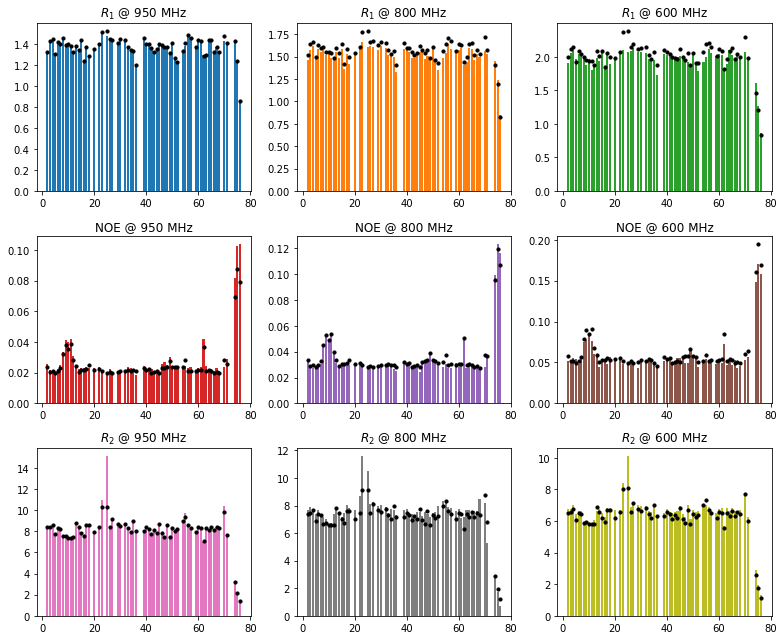

In [229]:
mf_nmr=MF(Type='NMR',n=3)
_=mf_nmr.plot_rates()

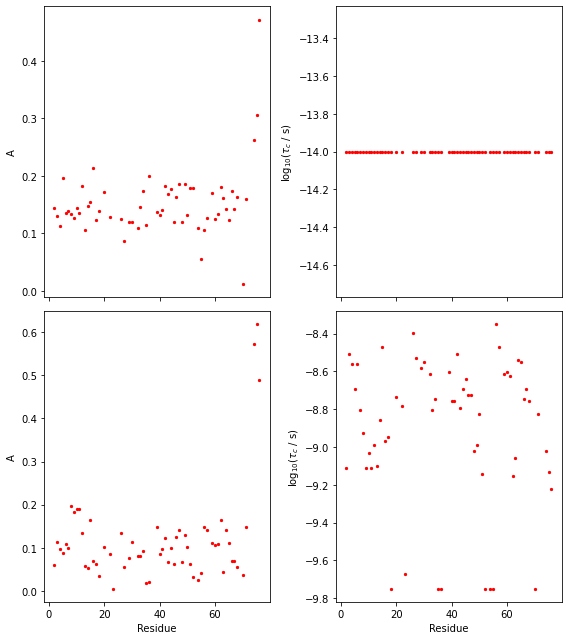

In [232]:
_=mf_nmr.plot_pars()

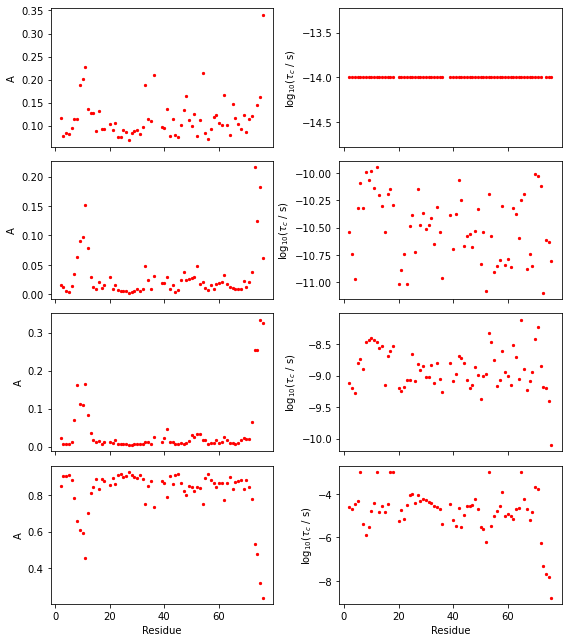

In [233]:
_=mf.plot_pars()

In [238]:
proj['MD']['no_opt'].detect.r_target(proj['NMR']['proc'][0].sens.rhoz,n=7)
proj['MD']['no_opt'].fit()
proj['MD']['proc'][-1].opt2dist(rhoz=proj['NMR']['proc'][0].sens.rhoz)

Fitted 2 data objects
o7:MD:ubi with 72 data points


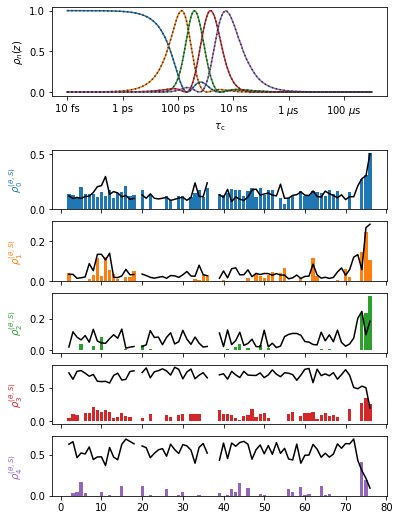

In [240]:
proj.close_fig('all')
proj['p5:NMR:ubi_soln'].plot(style='bar')
proj['MD']['opt_fit'][-1].plot()
proj.plot_obj.fig.set_size_inches([6,9])

array([<AxesSubplot:title={'center':'$R_1$ @ 950 MHz'}>,
       <AxesSubplot:title={'center':'$R_1$ @ 800 MHz'}>,
       <AxesSubplot:title={'center':'$R_1$ @ 600 MHz'}>,
       <AxesSubplot:title={'center':'NOE @ 950 MHz'}>,
       <AxesSubplot:title={'center':'NOE @ 800 MHz'}>,
       <AxesSubplot:title={'center':'NOE @ 600 MHz'}>,
       <AxesSubplot:title={'center':'$R_2$ @ 950 MHz'}>,
       <AxesSubplot:title={'center':'$R_2$ @ 800 MHz'}>,
       <AxesSubplot:title={'center':'$R_2$ @ 600 MHz'}>], dtype=object)

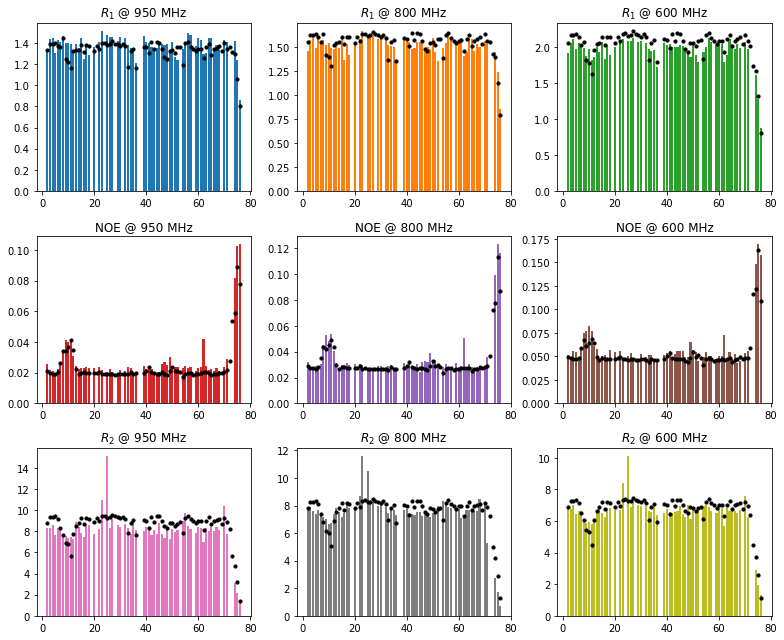

In [124]:
mf.plot_rates()

array([[<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:ylabel='A'>,
        <AxesSubplot:ylabel='$\\log_{10}(\\tau_c$ / s$)$'>],
       [<AxesSubplot:xlabel='Residue', ylabel='A'>,
        <AxesSubplot:xlabel='Residue', ylabel='$\\log_{10}(\\tau_c$ / s$)$'>]],
      dtype=object)

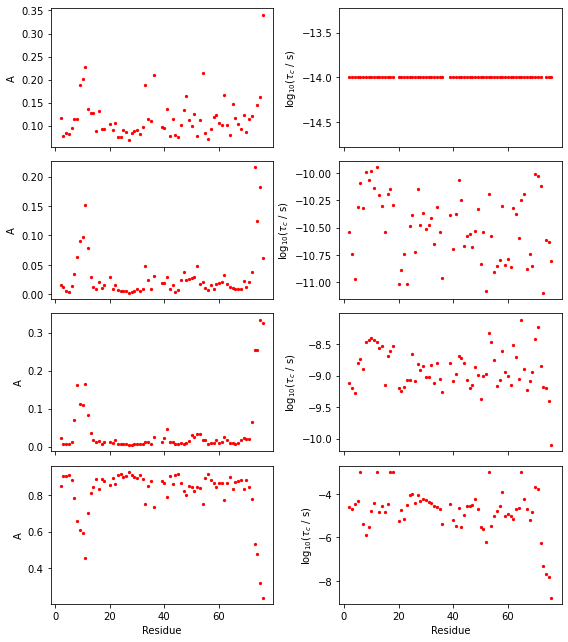

In [137]:
mf.plot_pars()

In [133]:
(mf_nmr.A<1e-3).sum()

33

Iterations |██████████████████████████████| 100%  of 16 steps
Completed
Data already in project (index=9)


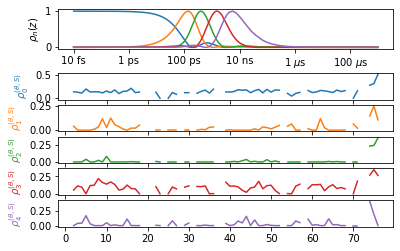

In [237]:
mf_nmr.n=5
proj.close_fig('all')
mf_nmr.data.plot()